#Import all the important libraries

In [ ]:
## import commands of different important libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image

# import command for sequential layer
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

# dense,flaten and pooling layers
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the CSV file of the dataset for labels using Numpy

Google Drive link:
https://drive.google.com/drive/folders/1nRT_qJzWThMmjfHSSBvORTndFt4sIhEh?usp=drive_link

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle-medicine/Training_set.csv')

In [ ]:
df

,filename,label
0,Image_1.jpg,Bioflu
1,Image_2.jpg,Bactidol
2,Image_3.jpg,Fish Oil
3,Image_4.jpg,Fish Oil
4,Image_5.jpg,Bioflu
...,...,...
6995,Image_6996.jpg,Alaxan
6996,Image_6997.jpg,DayZinc
6997,Image_6998.jpg,Medicol
6998,Image_6999.jpg,Bactidol


# Checking if there are any null values in the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7000 non-null   object
 1   label     7000 non-null   object
dtypes: object(2)
memory usage: 109.5+ KB


#Run this if you want to divide your dataset properly into class in a folder

In [ ]:
#run this if you want to divide your dataset properly into class in a folder

csv_file_path = '/content/drive/MyDrive/kaggle-medicine/Training_set.csv'
df = pd.read_csv(csv_file_path)


source_directory = '/content/drive/MyDrive/kaggle-medicine/train'


for index, row in df.iterrows():
    image_name = row['filename']
    folder_name = row['label']

    destination_folder = os.path.join(source_directory, folder_name)
    os.makedirs(destination_folder, exist_ok=True)

    source_path = os.path.join(source_directory, image_name)
    destination_path = os.path.join(destination_folder, image_name)

    shutil.move(source_path, destination_path)

print("Image organization completed.")


In [ ]:
# checking Image size

image_path = "/content/drive/MyDrive/kaggle-medicine/train/Alaxan/Image_1003.jpg"
image = Image.open(image_path)

image_size = image.size

print(f"Image size: {image_size}")


Image size: (300, 300)


# Deep Learning Model Parameters

In [ ]:
BATCH_SIZE =52
IMAGE_SIZE = 300
CHANNELS=3

In [ ]:
# Load your dataset using keras
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/kaggle-medicine/Sorted_Training_Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 7000 files belonging to 10 classes.


In [ ]:
# check the class namnes in dataset
class_names = dataset.class_names
class_names

['Alaxan',
 'Bactidol',
 'Bioflu',
 'Biogesic',
 'DayZinc',
 'Decolgen',
 'Fish Oil',
 'Kremil S',
 'Medicol',
 'Neozep']

In [ ]:
#check for image batch shape
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)

(52, 300, 300, 3)


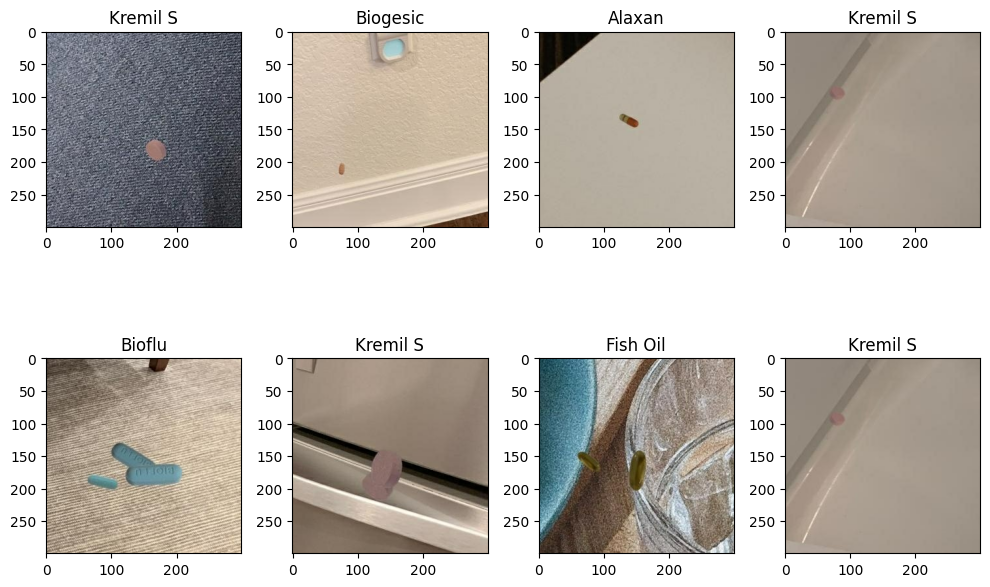

In [ ]:
# plot random images from the folder
plt.figure(figsize=(10, 10))
num_images_to_plot = 8

for _ in range(num_images_to_plot):
    image_batch, label_batch = next(iter(dataset))
    num_images_in_batch = image_batch.shape[0]
    random_index = np.random.randint(0, num_images_in_batch)
    ax = plt.subplot(3, 4, _ + 1)
    plt.imshow(image_batch[random_index].numpy().astype('uint8'))
    plt.title(class_names[label_batch[random_index]])

plt.tight_layout()
plt.show()

In [ ]:
# divide the dataset into training and validation

def get_data_partition(ds,training_size=0.8,val_size=0.2):
  # taking length of dataset
  len_ds=len(ds)

  # taking length of partition
  training=int(len_ds*training_size)
  val=int(len_ds*val_size)
   ## Taking values of partition
  train_ds=ds.take(training)
  val_ds=ds.skip(training).take(val)

  return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_data_partition(dataset)

In [ ]:
# importing resizing and rescaling using keras
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define image size
IMAGE_SIZE = (300,300)  # Example size; modify as needed

# Create a sequential model for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),  # Directly use layers.Resizing
    layers.Rescaling(1./255),                       # Directly use layers.Rescaling
])


In [ ]:
# Apply the resizing and rescaling on train_ds and val_ds
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
    )

val_ds= val_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
    )

# CNN Model

In [ ]:
# CNN Model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =10
def Model(train,val):
    model = models.Sequential([
    # resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),


    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')])

    model.build(input_shape=input_shape)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    with tf.device('/device:GPU:0'):
        history = model.fit(train, validation_data=val, batch_size=BATCH_SIZE, epochs=100)

    return model, history

In [ ]:
CNN_Model, history =Model(train_ds,val_ds)

Epoch 1/100
108/108 [==============================] - 391s 4s/step - loss: 2.3041 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.0990
Epoch 2/100
108/108 [==============================] - 23s 206ms/step - loss: 2.1716 - accuracy: 0.1658 - val_loss: 1.9567 - val_accuracy: 0.2370
Epoch 3/100
108/108 [==============================] - 23s 206ms/step - loss: 1.7057 - accuracy: 0.3097 - val_loss: 1.4431 - val_accuracy: 0.4025
Epoch 4/100
108/108 [==============================] - 23s 207ms/step - loss: 1.3480 - accuracy: 0.4537 - val_loss: 1.1917 - val_accuracy: 0.5397
Epoch 5/100
108/108 [==============================] - 23s 205ms/step - loss: 1.0982 - accuracy: 0.5776 - val_loss: 1.0455 - val_accuracy: 0.5961
Epoch 6/100
108/108 [==============================] - 23s 209ms/step - loss: 0.8628 - accuracy: 0.6745 - val_loss: 0.7324 - val_accuracy: 0.7507
Epoch 7/100
108/108 [==============================] - 23s 205ms/step - loss: 0.6499 - accuracy: 0.7726 - val_loss: 0.5956 - v

In [ ]:
# saving CNN model
CNN_Model.save("/content/drive/MyDrive/kaggle-medicine/Visual/CNN_Model_100.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


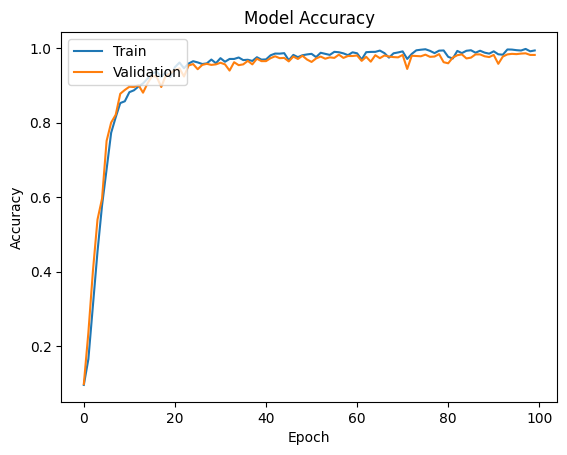

In [ ]:
# Plotting Trainign accuracy and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# saving training history of the model using numpy

np.save('/content/drive/MyDrive/kaggle-medicine/Visual/CNN_training_history_100.npy', history.history)

In [ ]:
CNN_eval = CNN_Model.evaluate(val_ds)

print("VGG19 Model Accuracy:", CNN_eval[1])

27/27 [==============================] - 13s 77ms/step - loss: 0.2188 - accuracy: 0.9501
VGG19 Model Accuracy: 0.9501445293426514


# VGG19 Model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, callbacks

def create_vgg19_model(input_shape, num_classes):
    # Load VGG19 model without the fully connected layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the VGG19 base layers to prevent overfitting
    vgg19_base.trainable = False

    # Add custom fully connected layers with Dropout and Batch Normalization
    flatten_layer = layers.Flatten()(vgg19_base.output)

    # Add a Dense layer with Batch Normalization and Dropout
    dense_layer = layers.Dense(512, activation='relu')(flatten_layer)
    batch_norm_layer = layers.BatchNormalization()(dense_layer)
    dropout_layer = layers.Dropout(0.5)(batch_norm_layer)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(dropout_layer)

    # Create the model
    model = models.Model(inputs=vgg19_base.input, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (300, 300, 3)
num_classes = 10

# Create VGG19 model
vgg19_model = create_vgg19_model(input_shape, num_classes)

# Compile the model
vgg19_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Display model summary
vgg19_model.summary()

# Define callbacks for early stopping
early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Example code for model training (you need to replace `train_data` and `val_data` with your actual data)
history = vgg19_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
    batch_size=32
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 300, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 150, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 41,265,738 (157.42 MB)

 Trainable params: 21,240,330 (81.03 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.3141 - loss: 2.2549 - val_accuracy: 0.3497 - val_loss: 2.8844
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.6964 - loss: 0.9025 - val_accuracy: 0.6264 - val_loss: 1.1381
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.8147 - loss: 0.5535 - val_accuracy: 0.6929 - val_loss: 0.9887
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.8775 - loss: 0.3946 - val_accuracy: 0.5903 - val_loss: 1.3929
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.9128 - loss: 0.2915 - val_accuracy: 0.6611 - val_loss: 1.1783
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9241 - loss: 0.2510 - val_accuracy: 0.7240 - val_loss: 0.9700
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.9494 - loss: 0.1903 - val_accuracy: 0.7204 - val_loss: 1.1073
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.9572 - loss: 0.1

In [ ]:
vgg19_model.save("/content/drive/MyDrive/kaggle-medicine/Visual/VGG19_model3_30.h5")

In [ ]:
np.save('/content/drive/MyDrive/kaggle-medicine/Visual/vgg19_training_history3_30.npy', history.history)

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

def create_vgg19_model(input_shape, num_classes):
    # Load VGG19 model without the fully connected layers
    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    vgg19_base.trainable = False

    # Add custom fully connected layers
    flatten_layer = layers.Flatten()(vgg19_base.output)
    dense_layer = layers.Dense(512, activation='relu')(flatten_layer)
    output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)

    # Create the model
    model = models.Model(inputs=vgg19_base.input, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (300, 300, 3)
num_classes = 10

# Create VGG19 model
vgg19_model = create_vgg19_model(input_shape, num_classes)

# Compile the model
vgg19_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Display model summary
vgg19_model.summary()


80134624/80134624 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [ ]:
with tf.device('/device:GPU:0'):
  history12 = vgg19_model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=100)

Epoch 1/100
108/108 [==============================] - 43s 330ms/step - loss: 3.8501 - accuracy: 0.2796 - val_loss: 1.6795 - val_accuracy: 0.4400
Epoch 2/100
108/108 [==============================] - 33s 302ms/step - loss: 1.2723 - accuracy: 0.5906 - val_loss: 1.2299 - val_accuracy: 0.5889
Epoch 3/100
108/108 [==============================] - 33s 301ms/step - loss: 0.8931 - accuracy: 0.7358 - val_loss: 0.9986 - val_accuracy: 0.6655
Epoch 4/100
108/108 [==============================] - 33s 303ms/step - loss: 0.6778 - accuracy: 0.8031 - val_loss: 0.8762 - val_accuracy: 0.7132
Epoch 5/100
108/108 [==============================] - 33s 301ms/step - loss: 0.5312 - accuracy: 0.8517 - val_loss: 0.8124 - val_accuracy: 0.7305
Epoch 6/100
108/108 [==============================] - 33s 300ms/step - loss: 0.4253 - accuracy: 0.8864 - val_loss: 0.8317 - val_accuracy: 0.7240
Epoch 7/100
108/108 [==============================] - 33s 302ms/step - loss: 0.3448 - accuracy: 0.9124 - val_loss: 0.6960 -

In [ ]:
vgg19_model.save("/content/drive/MyDrive/kaggle-medicine/Visual/VGG19_model3_100.h5")

In [ ]:
np.save('/content/drive/MyDrive/kaggle-medicine/Visual/vgg19_training_history3_100.npy', history12.history)

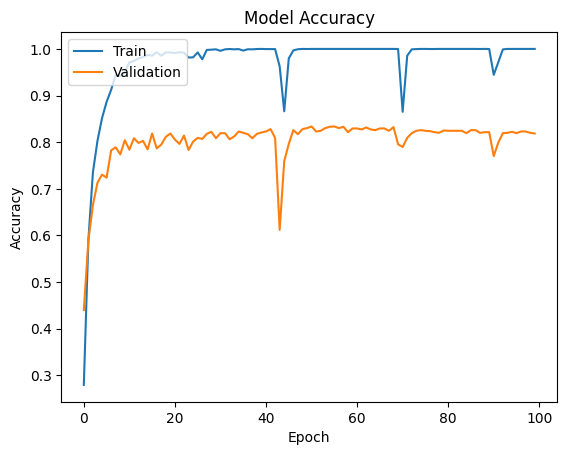

In [ ]:
plt.plot(history12.history['accuracy'])
plt.plot(history12.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# InceptionResnetv2 Model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models

def create_inceptionresnetv2_model(input_shape, num_classes):
    # Load InceptionResNetV2 with pre-trained weights
    inceptionresnetv2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in inceptionresnetv2_model.layers:
        layer.trainable = False


    x = layers.GlobalAveragePooling2D()(inceptionresnetv2_model.output)
    x = layers.Dense(512, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)


    model = models.Model(inputs=inceptionresnetv2_model.input, outputs=output_layer)

    return model

# Example usage:
input_shape = (300, 300, 3)
n_classes = 10
inceptionresnetv2_model = create_inceptionresnetv2_model(input_shape, n_classes)
inceptionresnetv2_model.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])


inceptionresnetv2_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_203 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_203   │ (None, 149, 149, 32)   │             96 │ conv2d_203[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_203            │ (None, 149, 149, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_204 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_203[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_204   │ (None, 147, 147, 32)   │             96 │ conv2d_204[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_204            │ (None, 147, 147, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_205 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_204[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_205   │ (None, 147, 147, 64)   │            192 │ conv2d_205[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_205            │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_205[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_206 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_206   │ (None, 73, 73, 80)     │            240 │ conv2d_206[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_206            │ (None, 73, 73, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_207 (Conv2D)  

 Total params: 55,128,810 (210.30 MB)

 Trainable params: 792,074 (3.02 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
history2 = inceptionresnetv2_model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=25)

Epoch 1/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4427 - loss: 1.6535 - val_accuracy: 0.6835 - val_loss: 0.9122
Epoch 2/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.7090 - loss: 0.8431 - val_accuracy: 0.7283 - val_loss: 0.7969
Epoch 3/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.7693 - loss: 0.6877 - val_accuracy: 0.7305 - val_loss: 0.7596
Epoch 4/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.8013 - loss: 0.6046 - val_accuracy: 0.7384 - val_loss: 0.7286
Epoch 5/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.7987 - loss: 0.5710 - val_accuracy: 0.7565 - val_loss: 0.6800
Epoch 6/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.8325 - loss: 0.4764 - val_accuracy: 0.7811 - val_loss: 0.6306
Epoch 7/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.8461 - loss: 0.4517 - val_accuracy: 0.7832 - val_loss: 0.6104
Epoch 8/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.8592 - loss: 0.4

In [ ]:
inceptionresnetv2_model.save("/content/drive/MyDrive/kaggle-medicine/Final_Models/Inceptionresnetv2_model_100.keras")

In [ ]:
np.save('/content/drive/MyDrive/kaggle-medicine/Final_Models/inceptionresnetv2_training_history_100.npy', history2.history)

In [ ]:
inceptionresnetv2_model.save("/content/drive/MyDrive/kaggle-medicine/Final_Models/Inceptionresnetv2_model_100.h5")